In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import datetime as dt

## Procesamiento de datos

In [227]:
dataset_sube = pd.read_csv('data/sube-2023.csv')

### Ejercicio 1

#### a)

In [228]:
dataset_sube['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube['DIA_TRANSPORTE'], format='%Y-%m-%d')

#### b)

##### i.

In [229]:
def obtener_nombre_dia(fecha_dia):
    dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    return dias[fecha_dia.weekday()]

In [230]:
dataset_sube['FECHA_DIA'] = dataset_sube['DIA_TRANSPORTE'].apply(obtener_nombre_dia)

##### ii.

In [231]:
dataset_sube['FECHA_ORDINAL'] = dataset_sube['DIA_TRANSPORTE'].dt.day_of_year

##### iii.

In [232]:
dataset_sube

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_ORDINAL
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Domingo,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Domingo,1
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO,Domingo,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Domingo,1
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO,Domingo,1
...,...,...,...,...,...,...,...,...,...,...,...,...
472286,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL A,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,28,NO,Domingo,365
472287,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL B,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,38,NO,Domingo,365
472288,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL C,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,54,NO,Domingo,365
472289,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL D,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,52,NO,Domingo,365


### Ejercicio 2

### Ejercicio 3

## Analisis exploratorio

### Ejercicio 4

## Modelado

### Ejercicio 5

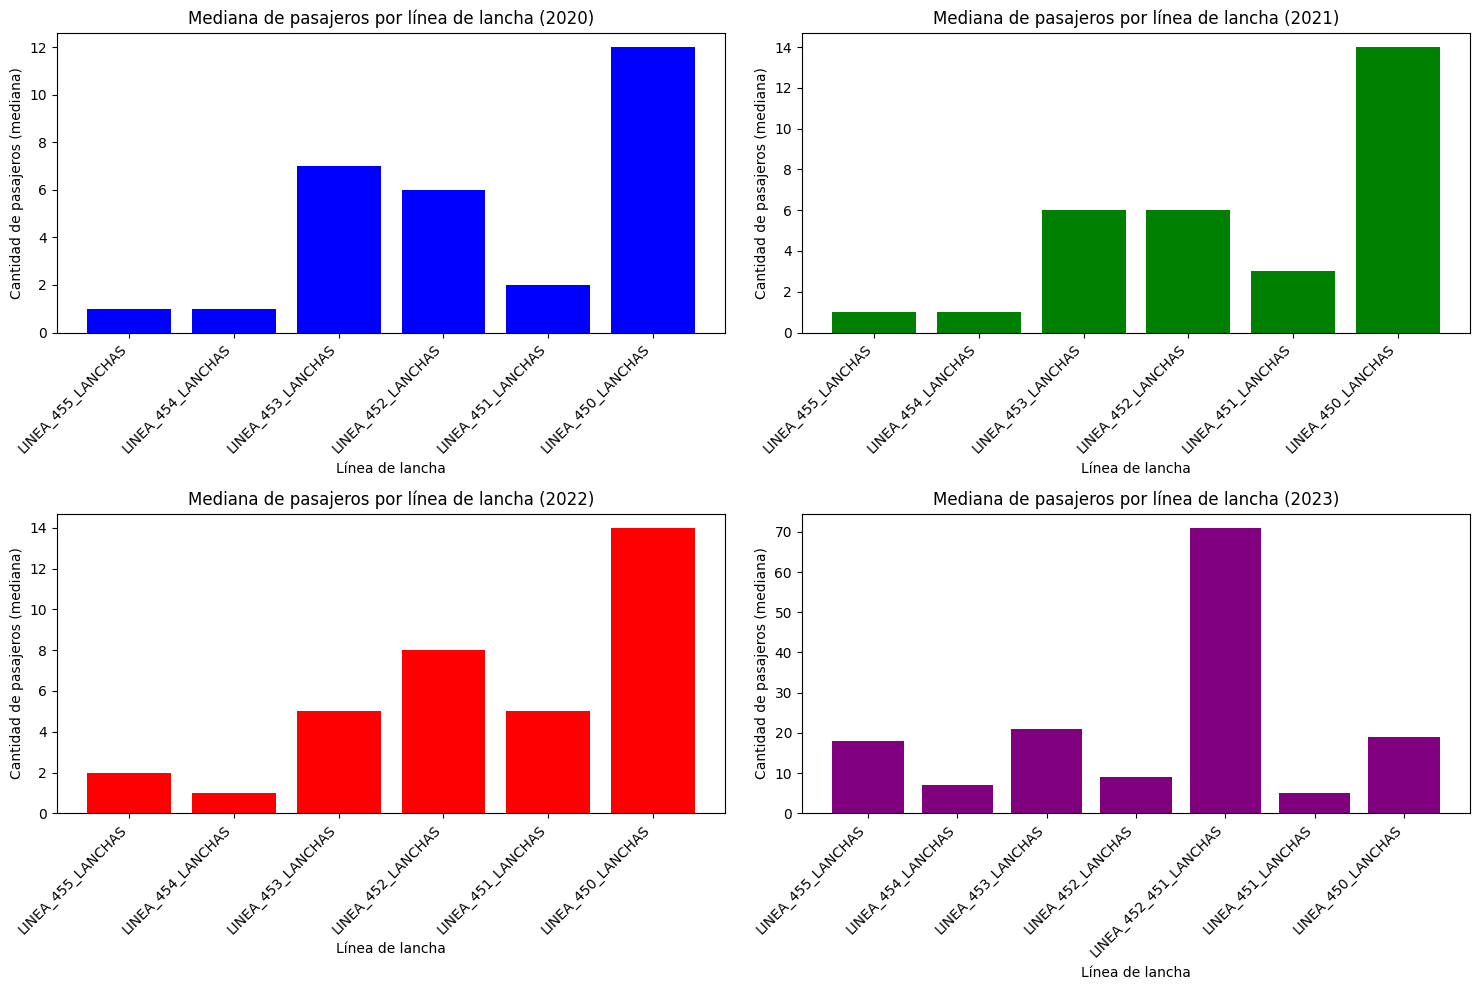

In [233]:
dataset_sube20 = pd.read_csv('data/dat-ab-usos-2020.csv')
dataset_sube21 = pd.read_csv('data/dat-ab-usos-2021.csv')
dataset_sube22 = pd.read_csv('data/dat-ab-usos-2022.csv')
#creo un nuevo DataFrame con todos los años
df_concatenado = pd.concat([dataset_sube20,dataset_sube21,dataset_sube22,dataset_sube])

# Creo una columna para el año en el nuevo dataframe
df_concatenado['DIA_TRANSPORTE'] = pd.to_datetime(df_concatenado['DIA_TRANSPORTE'])
df_concatenado['AÑO'] = df_concatenado['DIA_TRANSPORTE'].dt.year

# Filtro los datos solo para lanchas
lanchas_data = df_concatenado[df_concatenado['TIPO_TRANSPORTE'] == 'LANCHAS']

# Creo una función para obtener las medianas por año
def obtener_medianas_por_año(data, year):
    data_año = data[data['AÑO'] == year]
    medianas = data_año.groupby('LINEA')['CANTIDAD'].median().reset_index()
    return medianas.sort_values(by='LINEA', ascending=False)

# Obtengo las medianas para cada año en especifico
lanchas_medianas20 = obtener_medianas_por_año(lanchas_data, 2020)
lanchas_medianas21 = obtener_medianas_por_año(lanchas_data, 2021)
lanchas_medianas22 = obtener_medianas_por_año(lanchas_data, 2022)
lanchas_medianas23 = obtener_medianas_por_año(lanchas_data, 2023)

# Creo una nueva figura y ejes para el gráfico combinado
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 2020
axes[0, 0].bar(lanchas_medianas20['LINEA'], lanchas_medianas20['CANTIDAD'], color='b')
axes[0, 0].set_title('Mediana de pasajeros por línea de lancha (2020)')
axes[0, 0].set_xlabel('Línea de lancha')
axes[0, 0].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# Gráfico 2021
axes[0, 1].bar(lanchas_medianas21['LINEA'], lanchas_medianas21['CANTIDAD'], color='g')
axes[0, 1].set_title('Mediana de pasajeros por línea de lancha (2021)')
axes[0, 1].set_xlabel('Línea de lancha')
axes[0, 1].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Gráfico 2022
axes[1, 0].bar(lanchas_medianas22['LINEA'], lanchas_medianas22['CANTIDAD'], color='r')
axes[1, 0].set_title('Mediana de pasajeros por línea de lancha (2022)')
axes[1, 0].set_xlabel('Línea de lancha')
axes[1, 0].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Gráfico 2023
axes[1, 1].bar(lanchas_medianas23['LINEA'], lanchas_medianas23['CANTIDAD'], color='purple')
axes[1, 1].set_title('Mediana de pasajeros por línea de lancha (2023)')
axes[1, 1].set_xlabel('Línea de lancha')
axes[1, 1].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

# Ajusto el espacio entre los subgráficos
plt.tight_layout()

# Muestro el gráfico
plt.show()

Estos gráficos no solo muestran cómo varió la mediana de pasajeros en las diferentes líneas de lancha durante los años 2020, 2021, 2022 y 2023, sino que también reflejan las posibles influencias externas que han afectado el uso del transporte acuático en los últimos años.
En el gráfico del año 2020 se puede observar que la mediana es significativamente menor que la de los siguientes años ya que por la pandemia covid-19, la mayoría de personas no podían salir de sus casas y por ende se redujo el uso las lanchas, en el próximo gráfico analizaremos este interesante año más en detalle.
En 2021, la mediana de pasajeros se estabilizó en comparación con 2020. Las diferencias entre las líneas no son tan marcadas, lo que podría significar una distribución más uniforme del uso de las lanchas. Esto puede ser resultado de cambios en las políticas de transporte o adaptaciones a nuevas rutas.
En 2022, se nota una tendencia hacia un aumento en la mediana de pasajeros en varias líneas, indicando una posible recuperación en el uso de las lanchas. Este incremento podría estar relacionado con la reactivación económica y un regreso gradual a la normalidad post-pandemia.
En 2023, se puede ver un gran aumento en la mediana de la cantidad de pasajeros en comparación a los años anteriores, se podría decir que se esta normalizando la movilidad y el uso de los transportes acuaticos despues de la pandemía.

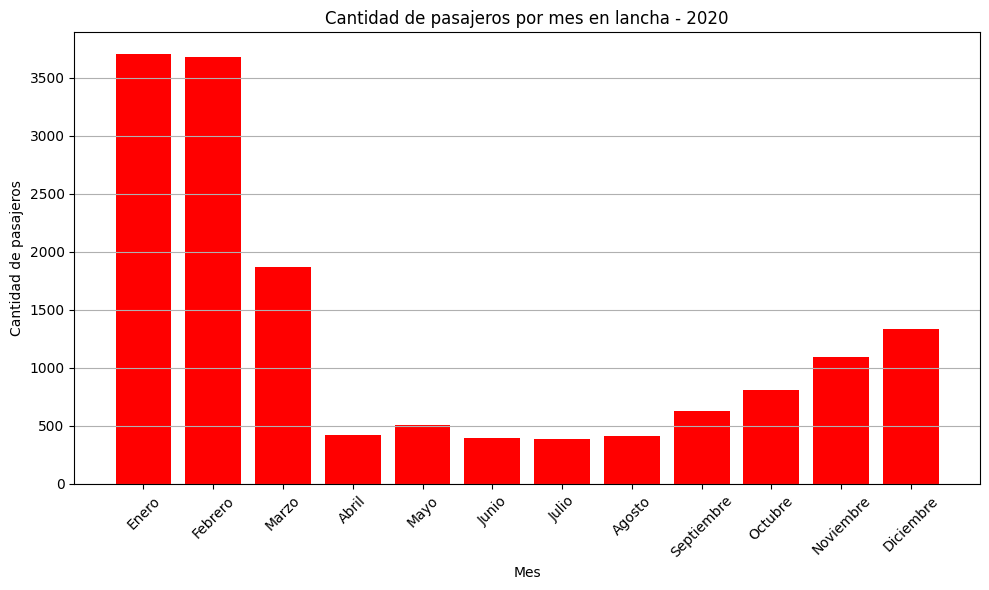

In [238]:
# Creo una columna para el mes en el DataFrame del año 2020
dataset_sube20['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube20['DIA_TRANSPORTE'])
dataset_sube20['MES'] = dataset_sube20['DIA_TRANSPORTE'].dt.month

# Filtro los datos solo para lanchas
lanchas_data_2020 = dataset_sube20[dataset_sube20['TIPO_TRANSPORTE'] == 'LANCHAS']

# Obtengo la suma de pasajeros por mes
pasajeros_por_mes = lanchas_data_2020.groupby('MES')['CANTIDAD'].sum().reset_index()

# Creo el gráfico
plt.figure(figsize=(10, 6))
plt.bar(pasajeros_por_mes['MES'], pasajeros_por_mes['CANTIDAD'], color='r')
plt.title('Cantidad de pasajeros por mes en lancha - 2020')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(pasajeros_por_mes['MES'], ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], rotation=45)
plt.grid(axis='y')

# Muestro el gráfico
plt.tight_layout()
plt.show()

En este gráfico podemos observar mejor cómo afectó la pandemia en el uso de las lanchas. Más allá de que generalmente en los meses del verano (Enero, Febrero, Marzo) se utilizan las lanchas en mayor cantidad que otros meses del año, ya que el clima es caluroso y la gente elije pasar tiempo en el rio, hay que tener en cuenta que en el 2020 en particular en Marzo inició la pandemia por ende esto hace que la diferencia de la mediana de cantidad de pasajeros entre los meses del verano y los demás meses del año sea mayor que lo normal.
Luego se puede observar un aumento gradual en la segunda mitad del año, esto podría indicar una recuperación en el uso de las lanchas a medida que las restricciones se relajaban y las personas comenzaban a retomar sus actividades normales.

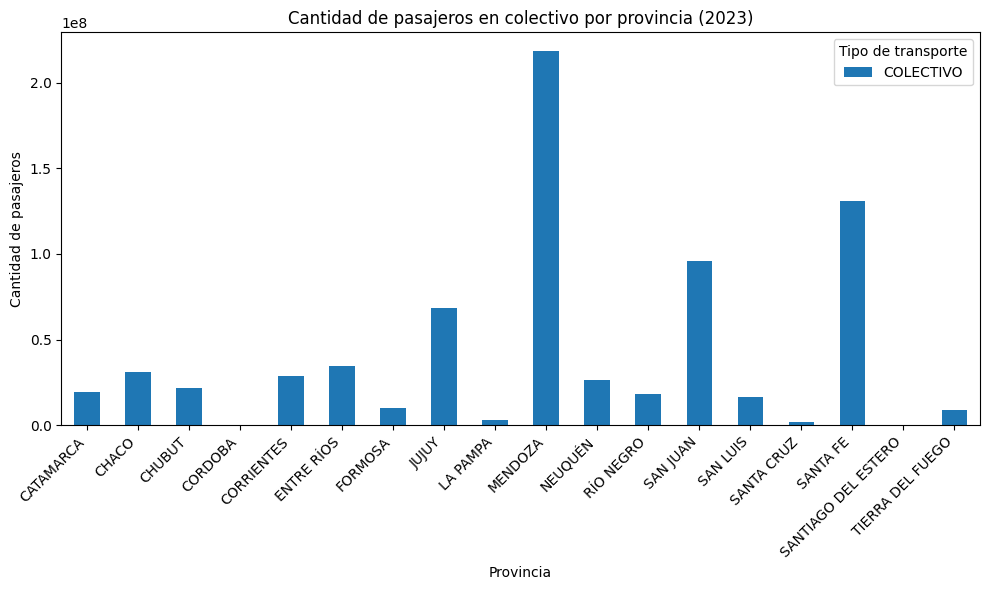

In [234]:
datosSinBAJN = dataset_sube[(dataset_sube["PROVINCIA"] != "JN") & (dataset_sube["PROVINCIA"] != "BUENOS AIRES")]
datos_agrupados = datosSinBAJN.groupby(['PROVINCIA', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().unstack()

# Crear el gráfico de barras
datos_agrupados.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Cantidad de pasajeros en colectivo por provincia (2023)')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de transporte')
plt.tight_layout()
plt.show()

C:\Users\fatima.jordan\AppData\Local\Temp\ipykernel_3968\2134484132.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datosSoloBAJN = datosSoloBAJN[(datosSoloBAJN["PROVINCIA"] == "JN") | (dataset_sube["PROVINCIA"] == "BUENOS AIRES")]


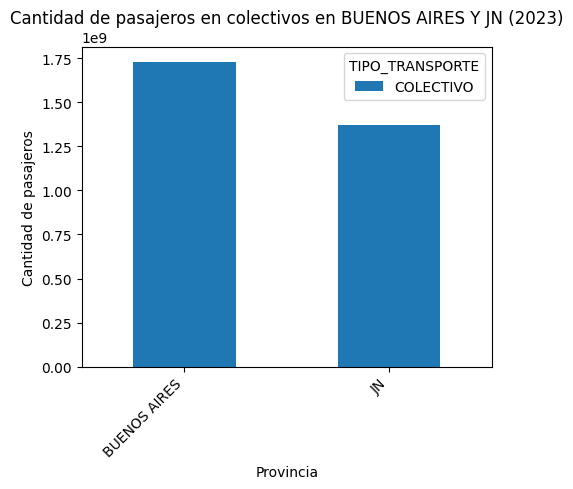

In [235]:
datosSoloBAJN = dataset_sube[dataset_sube["TIPO_TRANSPORTE"]=="COLECTIVO"]
datosSoloBAJN = datosSoloBAJN[(datosSoloBAJN["PROVINCIA"] == "JN") | (dataset_sube["PROVINCIA"] == "BUENOS AIRES")]
datos_agrupados2 = datosSoloBAJN.groupby(['PROVINCIA', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().unstack()

# Crear el gráfico de barras apiladas
datos_agrupados2.plot(kind='bar', stacked=True, figsize=(5, 5))
plt.title('Cantidad de pasajeros en colectivos en BUENOS AIRES Y JN (2023)')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()